# <b>Question 1</b>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import sortedcontainers
import copy
%matplotlib inline

# <b>Question 2</b>

### <b> Part 1</b>

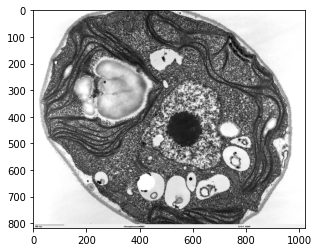

In [2]:
cell = cv2.imread("../images/cell.png")
cellG = cv2.cvtColor(cell,cv2.COLOR_BGR2GRAY)
plt.imshow(cellG,cmap='gray')

In [3]:
def otsuT(img):
    listThem = img.flatten()
    minT = np.min(img)
    maxT = np.max(img)
    minV = -10
    minTh = -10
    listColors = np.arange(minT+0.5,maxT-0.5,0.5)
    for i in listColors:
        foreG = listThem[listThem >= i]
        vF = np.var(foreG)
        backG = listThem[listThem < i]
        vB = np.var(backG)
        sigmaF = vF*(len(foreG)/len(listThem)) + vB*(len(backG)/len(listThem))
        if sigmaF < minV or minV == -10:
            minV = sigmaF
            minTh = i
    return minTh.astype('uint8')

In [4]:
def padding(pic,k):
    padNum = math.floor(k/2)
    padPic = np.zeros((pic.shape[0]+(2*padNum),pic.shape[1]+(2*padNum)))
    padPic[padNum:padPic.shape[0]-padNum, padNum:padPic.shape[1]-padNum] = pic
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    padPic[xStart:xEnd, yStart:yEnd] = pic
    return padPic

def dilate(img,k):
    padPic = padding(img,k)
    out = np.zeros_like(padPic)
    padNum = int(k/2)
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    StructE = np.ones((k,k),dtype='uint8')
    for i in range(xStart,xEnd):
        for j in range(yStart,yEnd):
            vals = padPic[i-padNum:i+padNum+1,j-padNum:j+padNum+1]
            vals = vals*StructE
            out[i,j] = np.min(vals)
    out = out[xStart:xEnd,yStart:yEnd]
    return out


def erode(img,k):
    padPic = padding(img,k)
    out = np.zeros_like(padPic)
    padNum = int(k/2)
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    StructE = np.ones((k,k),dtype='uint8')
    for i in range(xStart,xEnd):
        for j in range(yStart,yEnd):
            vals = padPic[i-padNum:i+padNum+1,j-padNum:j+padNum+1]
            vals = vals*StructE
            out[i,j] = np.max(vals)
    out = out[xStart:xEnd,yStart:yEnd]
    return out

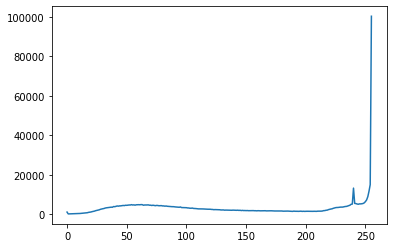

In [5]:
def drawHistogram(img):
    his = np.zeros(256,)
    a = img.flatten()
    for i in a:
        his[i] = his[i]+1
    return his
histg = drawHistogram(cellG)
# show the plotting graph of an image
plt.plot(histg)
plt.show()
# print(histg)

In [6]:
def findRoot(ar, unionIt):
    if unionIt[ar] == ar:
        return ar
    else:
        unionIt[ar] = findRoot(unionIt[ar], unionIt)
        return unionIt[ar]
    
def unionSet(ar1, ar2, unionIt):
    val1 = findRoot(ar1,unionIt)
    val2 = findRoot(ar2,unionIt)
    minVal = min(val1,val2)
    maxVal = max(val1,val2)
    unionIt[maxVal] = minVal
    
def connComponents(im):
    next_label = 1;
    labels = np.zeros(im.shape, dtype=int)
    linked = [0]
    h, w = im.shape
    for row in range(h):
        for column in range(w):
            if im[row, column] != 0:
                neighbors = []
                if row > 0:
                    if im[row-1][column] == im[row, column]:
                        neighbors.append((row-1, column))
                if row > 0 and column + 1 < im.shape[1]:
                    if im[row-1, column+1] == im[row, column]:
                        neighbors.append((row-1, column+1))
                if row > 0 and column > 0:
                    if im[row-1, column-1] == im[row, column]:
                        neighbors.append((row-1, column-1))
                if column > 0:
                    if (im[row, column-1] == im[row, column]):
                        neighbors.append((row, column-1))

                if len(neighbors) == 0:
                    linked.append(next_label)
                    labels[row, column] = next_label
                    next_label += 1
                
                else:
                    L = [labels[r, c] for r, c in neighbors]
                    labels[row, column] = min(L)
                    for label in L:
                        unionSet(label, labels[row, column], linked)
                        
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            if im[row, column] != 0:
                labels[row, column] = findRoot(labels[row, column], linked)
    return labels


In [7]:
def padding(pic,k):
    padNum = math.floor(k/2)
    padPic = np.zeros((pic.shape[0]+(2*padNum),pic.shape[1]+(2*padNum)))
    padPic[padNum:padPic.shape[0]-padNum, padNum:padPic.shape[1]-padNum] = pic
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    padPic[xStart:xEnd, yStart:yEnd] = pic
    return padPic.astype('int')


In [8]:
def gausFilter(img,s,q):
    k = math.floor(q/2)
    imgP = padding(img,k)
    out = np.zeros_like(imgP)
    sS = 2 * (s ** 2)
    kern = np.zeros([q,q])
    center = int(q/2)
    for i in range(q):
        for j in range(q):
            kern[i][j] = -1*((i-center)**2 + (j-center)**2)/s
    #For 3D
#     kern = np.dstack((kern,kern))
    for i in range(k,imgP.shape[0]-k):
        for j in range(k,imgP.shape[1]-k):
            kernCom = kern
            kernCom = np.exp(kernCom)
            out[i][j] = np.rint(np.sum(imgP[i-center:i+center+1,j-center:j+center+1]*kernCom,axis=(0,1))/np.sum(kernCom,axis=(0,1)))
    out = out[center:out.shape[0]-center,center:out.shape[1]-center]
    return out.astype('uint8')

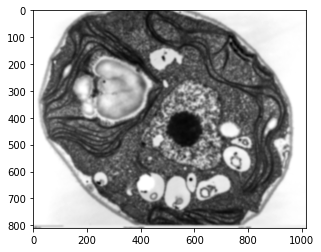

In [9]:
output = gausFilter(cellG, 17, 17)
img = output.copy()
plt.imshow(output,cmap='gray')

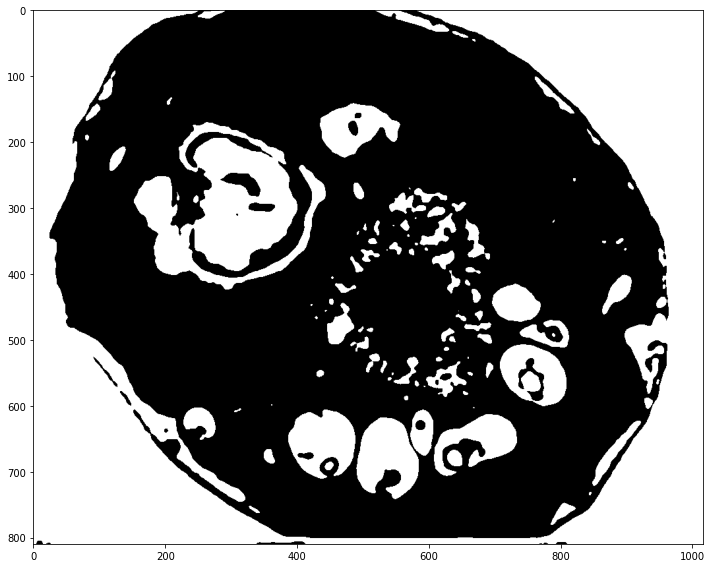

In [10]:
ret,cellOwn = cv2.threshold(img,170,255,cv2.THRESH_BINARY)
plt.figure(figsize=(12,12))
plt.imshow(cellOwn,cmap='gray')
plt.show()

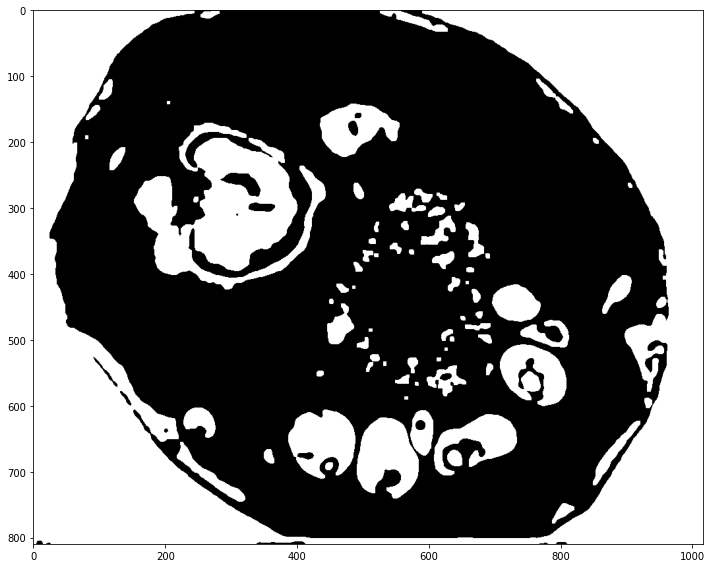

In [11]:
qq = dilate(cellOwn,5)
qq = erode(qq,5)
cellOwn = qq.copy()
plt.figure(figsize=(12,12))
plt.imshow(qq,cmap='gray')

In [12]:
cell2 = cellOwn.copy()
labels = connComponents(cell2)
restored_unique, restored_count = np.unique(labels, return_counts=True)
labels[labels==1] = -1
labels[labels==3] = -1
print("Number of parts = ",len(restored_unique[restored_unique!=0]))
print(np.unique(labels))
# print(restored_unique[restored_unique!=0])

Number of parts =  77
[ -1   0   2   4   9  10  11  12  13  30  35  38  50  60  61  62  64  65
  67  73  80  85  92  94  95 102 104 106 108 109 112 114 126 133 146 151
 153 154 156 158 164 166 167 168 169 176 178 184 199 201 207 208 209 213
 221 225 227 228 231 232 233 234 240 242 251 252 253 258 261 263 270 277
 284 307 308 309 315 322]


In [13]:
colorImg = np.zeros_like(labels)
print(colorImg.shape)
colorImg = np.dstack((colorImg,colorImg,colorImg))
print(colorImg.shape)

(810, 1016)
(810, 1016, 3)


In [14]:
count_unique = len(restored_unique[restored_unique!=0])
colorImg = np.zeros_like(labels)
colorImg = np.dstack((colorImg,colorImg,colorImg))
#Color List:
c = [(176, 23, 31),
     (255,182,193),
     (218,12,214),
     (139, 71,137),
     (0,    0,238),
     (198,226,255),
     (0,  245,255),
     (0,  255,127),
     (191, 62,255),
     (46, 139, 87),
     ( 0, 255,  0),
     (48, 128, 20),
     (255,255,  0),
     (139,139,  0),
     (238,201,  0),
     (255,222,173),
     (139, 37, 0)]
print(len(c))

17


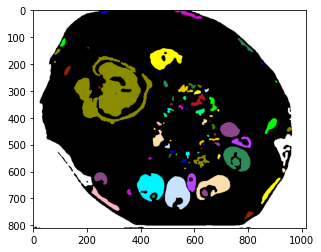

In [15]:
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j]>0:
            if labels[i,j] < len(c):
                assignColor = c[labels[i,j]]
            else: 
                assignColor = c[labels[i,j]% len(c)]
            colorImg[i,j] = assignColor
        if labels[i,j] == -1:     
            colorImg[i,j] = (255,255,255)
plt.imshow(colorImg)
plt.show()

### <b>Flower</b>

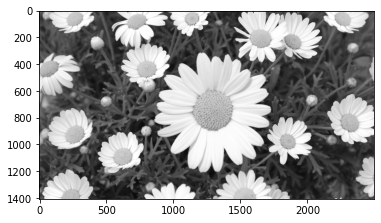

In [16]:
flow = cv2.imread("../images/flower.jpeg")
flowG = cv2.cvtColor(flow,cv2.COLOR_BGR2GRAY)
plt.imshow(flowG,cmap='gray')

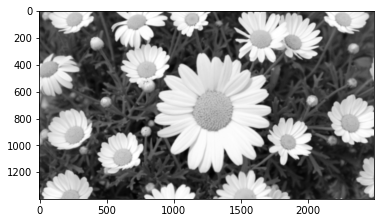

In [17]:
output = gausFilter(flowG, 17, 17)
img = output.copy()
plt.imshow(output,cmap='gray')

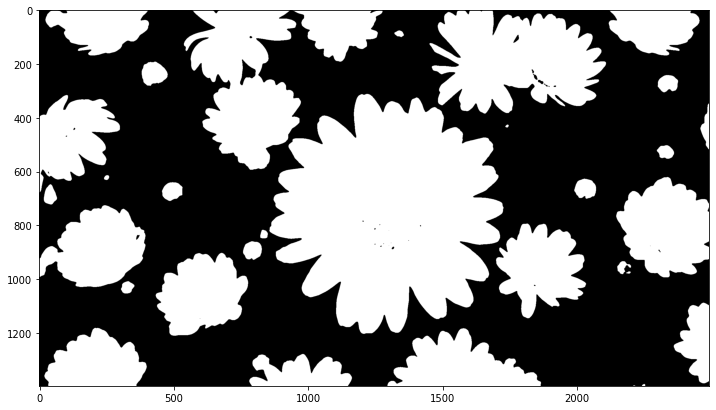

In [20]:
ret,flowOwn = cv2.threshold(img,140,255,cv2.THRESH_BINARY)
plt.figure(figsize=(12,12))
plt.imshow(flowOwn,cmap='gray')
plt.show()

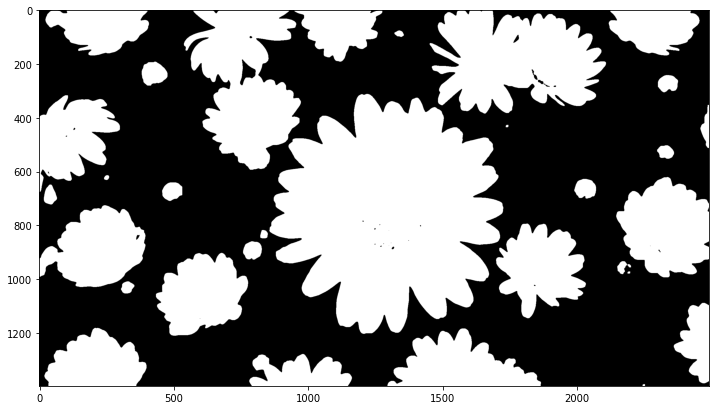

In [22]:
qq = dilate(flowOwn,5)
qq = erode(qq,5)
flowOwn = qq.copy()
plt.figure(figsize=(12,12))
plt.imshow(qq,cmap='gray')

In [27]:
floww = flowOwn.copy()
labels = connComponents(floww)
restored_unique, restored_count = np.unique(labels, return_counts=True)
print("Number of parts = ",len(restored_unique[restored_unique!=0]))
print(np.unique(labels))
# print(restored_unique[restored_unique!=0])

Number of parts =  32
[  0   1   2   4   6   9  78 166 185 228 235 283 318 367 388 391 397 411
 420 454 487 502 528 581 606 615 616 637 655 664 667 725 815]


In [28]:
colorImg = np.zeros_like(labels)
print(colorImg.shape)
colorImg = np.dstack((colorImg,colorImg,colorImg))
print(colorImg.shape)

(1398, 2492)
(1398, 2492, 3)


In [29]:
count_unique = len(restored_unique[restored_unique!=0])
#Color List:
c = [(176, 23, 31),
     (255,182,193),
     (218,12,214),
     (139, 71,137),
     (0,    0,238),
     (198,226,255),
     (0,  245,255),
     (0,  255,127),
     (191, 62,255),
     (46, 139, 87),
     ( 0, 255,  0),
     (48, 128, 20),
     (255,255,  0),
     (139,139,  0),
     (238,201,  0),
     (255,222,173),
     (139, 37, 0)]
print(len(c))

17


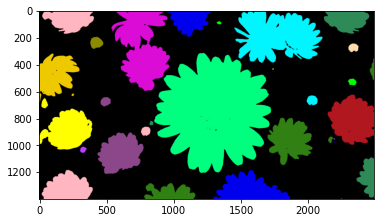

In [30]:
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j]>0:
            if labels[i,j] < len(c):
                assignColor = c[labels[i,j]]
            else: 
                assignColor = c[labels[i,j]% len(c)]
            colorImg[i,j] = assignColor
plt.imshow(colorImg)
plt.show()